# Test for systematics that become visible by comparison of multiple light curves in a campaign

## Run the LCs through appaloosa

In [18]:
for oid in oid_list:
    RunLC_test(oid)

/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

228682441	2018-03-02 14:45:12.534226	5	stars_shortlist/M67/hlsp_everest_k2_llc_228682441-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61103845



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211410963	2018-03-02 14:45:13.072755	15	stars_shortlist/M67/hlsp_everest_k2_llc_211410963-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61102064



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and w

211411112	2018-03-02 14:45:13.754801	13	stars_shortlist/M67/hlsp_everest_k2_llc_211411112-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61102002



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211416648	2018-03-02 14:45:14.340156	15	stars_shortlist/M67/hlsp_everest_k2_llc_211416648-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101947



/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and wi

211396422	2018-03-02 14:45:15.135825	5	stars_shortlist/M67/hlsp_everest_k2_llc_211396422-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.6110411



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211412571	2018-03-02 14:45:15.736016	22	stars_shortlist/M67/hlsp_everest_k2_llc_211412571-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101854



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: overflow encountered in exp
  lambda x: (_fd[0]*np

211418561	2018-03-02 14:45:16.363096	14	stars_shortlist/M67/hlsp_everest_k2_llc_211418561-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101919



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211418176	2018-03-02 14:45:16.997704	7	stars_shortlist/M67/hlsp_everest_k2_llc_211418176-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.611019



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211403974	2018-03-02 14:45:17.572362	4	stars_shortlist/M67/hlsp_everest_k2_llc_211403974-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61102172



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not 

211417817	2018-03-02 14:45:18.477134	9	stars_shortlist/M67/hlsp_everest_k2_llc_211417817-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101863



/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:703: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  sig_i = np.nanmedian(rolling_std(flux, std_window, center=True))
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * 

211413212	2018-03-02 14:45:19.016409	47	stars_shortlist/M67/hlsp_everest_k2_llc_211413212-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101805



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211427268	2018-03-02 14:45:19.882666	12	stars_shortlist/M67/hlsp_everest_k2_llc_211427268-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61102921



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211395699	2018-03-02 14:45:20.469454	13	stars_shortlist/M67/hlsp_everest_k2_llc_211395699-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61104284



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211411894	2018-03-02 14:45:21.028381	6	stars_shortlist/M67/hlsp_everest_k2_llc_211411894-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101788



/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:703: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  sig_i = np.nanmedian(rolling_std(flux, std_window, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(

211406540	2018-03-02 14:45:21.534381	3	stars_shortlist/M67/hlsp_everest_k2_llc_211406540-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.6110533



/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:703: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  sig_i = np.nanmedian(rolling_std(flux, std_window, center=True))
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


211407971	2018-03-02 14:45:22.012253	12	stars_shortlist/M67/hlsp_everest_k2_llc_211407971-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61101844



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211411722	2018-03-02 14:45:22.551300	7	stars_shortlist/M67/hlsp_everest_k2_llc_211411722-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61105339



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211427574	2018-03-02 14:45:23.090805	6	stars_shortlist/M67/hlsp_everest_k2_llc_211427574-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61103736



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211409099	2018-03-02 14:45:23.649025	4	stars_shortlist/M67/hlsp_everest_k2_llc_211409099-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61105375



/home/ekaterina/Documents/appaloosa/appaloosa/appaloosa.py:271: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  error = np.ones_like(time[isrl]) * np.nanmedian(rolling_std(flux_raw[isrl], win_size, center=True))
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:112: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(np.array(flux[x], dtype='float'), krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:74: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_sm = rolling_median(flux[dl[i]:dr[i]], krnl)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  flux_i_sm = rolling_median(flux_i, nptsmooth, center=True)
/home/ekaterina/Documents/appaloosa/appaloosa/detrend.py:359: FutureWarn

211405388	2018-03-02 14:45:24.240178	8	stars_shortlist/M67/hlsp_everest_k2_llc_211405388-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61105354



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not 

211411477	2018-03-02 14:45:25.630503	10	stars_shortlist/M67/hlsp_everest_k2_llc_211411477-c05_kepler_v2.0_lc.fits	5	68.935625	29.424381432364804	2306.61105357



/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: divide by zero encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in true_divide
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:88: RuntimeWarning: invalid value encountered in greater
  flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:95: RuntimeWarning: divide by zero encountered in true_divide
  lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
/home/ekaterina/Documents/appaloosa/appaloosa/aflare.py:96: RuntimeWarning: divide by zero encountered in true_divide
  _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]


In [93]:
import pandas as pd
import numpy as np
import os
from appaloosa import RunLC
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
#rcParams['font.sans-serif'] = ['Tahoma']

def RunLC_test(oid):
    loc = 'stars_shortlist/M67'
    tpf_loc = 'stars_shortlist/M67/ktwo{}-c05_lpd-targ.fits.gz'.format(oid)
    lc_loc = 'stars_shortlist/M67/hlsp_everest_k2_llc_{}-c05_kepler_v2.0_lc.fits'.format(oid)
    os.chdir('/home/ekaterina/Documents/appaloosa')
    RunLC(lc_loc, dbmode='everest', display=False, debug=False, dofake=False, writeout=True)
    return

def display_overlay(oid_list,location, start, stop):

    os.chdir(location)
    all_flux={}
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, oid in enumerate(oid_list):
        flux = pd.read_csv(str(oid)+'_flux.csv',
                          usecols = ['flux_gap','time'])
        s = start
        t = stop
        mean = flux.flux_gap.median()
        plt.plot(list(flux.time)[s:t],list(flux.flux_gap/mean)[s:t],label='EPIC {}'.format(oid))
    plt.show()
    return
    
def edges_to_bool(start_stop):
    
    rangeflare = []
    for i,row in start_stop.iterrows():
            rangeflare.append(list(range(row.istart,row.istop)))
    isflare = np.zeros(start_stop.istop.iloc[-1]+1)
    rangeflare = [item for sublist in rangeflare for item in sublist]

    np.put(isflare,rangeflare,np.ones_like(rangeflare))

    return isflare

def create_inflated_binoms(oid_list,p,maxlen,display=False):

    inflated_binoms={}
    for i in [1,3,5]:
        binom = 0
        for oid in oid_list:
            not_inflated = np.random.binomial(1,p[oid]/i,maxlen//i)
            inflated = [item for sublist in [[j]*i for j in not_inflated] for item in sublist]
            binom = np.add(inflated,binom)
        inflated_binoms[i]=binom
    if display == True:
        plt.plot(inflated_binoms[3])
    
    return inflated_binoms

def remove_systematics(seq,maxlen):
    
    #create cleaned data frame:
    systematics = list(seq[5<seq.sum(axis=1)].index)
    remove = sorted(list(set([item for sublist in [[i-1,i,i+1] for i in systematics] for item in sublist])))
    seq_drop = seq.drop(labels=remove)
    
    #overlap dirty, overlap clean:
    od = [seq[seq.sum(axis=1)>=i].shape[0] for i in range(21)]
    oc = [seq_drop[seq_drop.sum(axis=1)>=i].shape[0] for i in range(21)]

    #Calculate the binomial probability for cleaned version
    p = seq.sum()/maxlen
    return od, oc, p

def display_comparison(inflated_binoms, overlap_dirty,overlap_clean):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i,binom in inflated_binoms.items():
        overlap_binom, edges = np.histogram(binom, bins=21, range=(0,21))
        #print(overlap_binom)
        overlap_binom = np.cumsum(overlap_binom[::-1])[::-1]
        #print(overlap_binom,'\n',overlap)
        ax.plot(overlap_binom,label='{}-times inflated binomial distribution'.format(i))
    ax.plot(overlap_dirty,label='Real distribution with systematic errors')
    ax.plot(overlap_clean,label='Real distribution - systematics removed')
    #ax.plot(np.array(overlap)-overlap_binom,label='real-random')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_yscale('log')
    fig.show()
    return

def generate_sequence(oid_list,location):

    os.chdir(location)

    all_isflare = {}
    for oid in oid_list:

        start_stop = pd.read_csv(str(oid)+'_flares.csv',
                                usecols = ['istart','istop'])
        all_isflare[oid] = edges_to_bool(start_stop)

    maxlen = max([len(val) for key,val in all_isflare.items()])

    for key, val in all_isflare.items():
        all_isflare[key] = np.concatenate((val,np.zeros(maxlen-len(val))))
        #print(len(val))
    seq = pd.DataFrame(all_isflare)
    return maxlen, seq
    

In [82]:
os.chdir('/home/ekaterina/Documents/appaloosa')
oid_list = pd.read_csv('stars_shortlist/M67/M67_short.txt',names=['EPIC'])
oid_list = oid_list.EPIC.tolist()


## Use the results or jump in here if LCs have been processed earlier

### Import the flare candidates first and reframe as boolean arrays of flare/not flare in time domain

In [83]:
location = '/home/ekaterina/Documents/appaloosa/stars_shortlist/M67/results/test_01'
maxlen, seq = generate_sequence(oid_list, location)


### Remove systematics as time intervals where flares overlap for more than 30% of all LCs

In [84]:
overlap_dirty, overlap_clean, p = remove_systematics(seq,maxlen)

### Introduce a binomial distribution for comparison, also some where flare time point occur in clusters of 3 or 5 time points

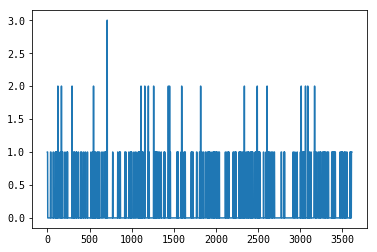

In [86]:
inflated_binoms = create_inflated_binoms(oid_list, p, maxlen,display=True)

### Now compare the cleaned version with the uncleaned one and also the (inflated) binomials:

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


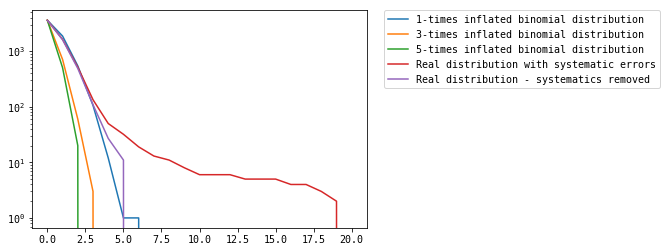

In [87]:
display_comparison(inflated_binoms, overlap_dirty, overlap_clean)

## Appendix: Example of a systematic in a light curve

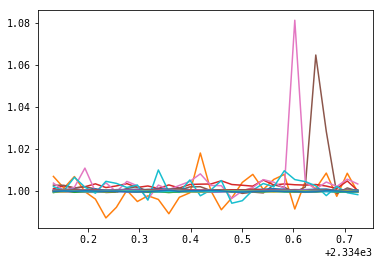

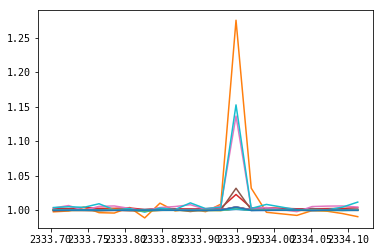

In [88]:
#FCOR
display_overlay(oid_list,location, 1330, 1360)
#FLUX
display_overlay(oid_list, location, 1310, 1330)


## WRAP-UP: Do all steps in one!

In [94]:
def wrap(location, oid_list, display=False):
    maxlen, seq = generate_sequence(oid_list, location)
    overlap_dirty, overlap_clean, p = remove_systematics(seq,maxlen)
    inflated_binoms = create_inflated_binoms(oid_list, p, maxlen,display=display)
    if display == True:
        display_comparison(inflated_binoms, overlap_dirty, overlap_clean)
        #FCOR
        display_overlay(oid_list,location, 1330, 1360)
        #FLUX
        display_overlay(oid_list, location, 1310, 1330)
    return overlap_dirty

loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/M67/results/test_11'

d11 = wrap(loc,oid_list,display=False)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


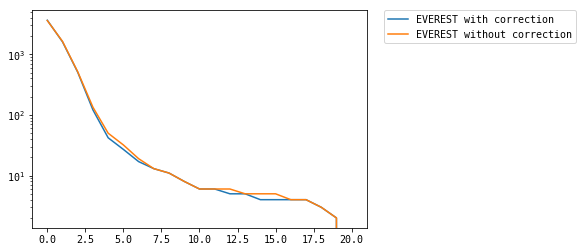

In [96]:
d01 = wrap(location,oid_list,display=False)

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(d11,label='EVEREST with correction')
ax.plot(d01, label = 'EVEREST without correction')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_yscale('log')
f.show()    